In [56]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
import shutil
import os
import time
from PIL import Image

In [ ]:
"""

This data handler can:
unzip (train, val and test),
resize (train, val and test),
split (into task1 and 2),
combine (traina and val) the data.

"""

In [60]:
# Set the paths for the data and the ground truth files
train_dir = "D:/msc/data/ISIC-2017_Training_Data"
train_truth = "D:/msc/data/ISIC-2017_Training_Part3_GroundTruth.csv"

test_dir = "D:/msc/data/ISIC-2017_Test_v2_Data"
test_truth = "D:/msc/data/ISIC-2017_Test_v2_Part3_GroundTruth.csv"

val_dir = "D:/msc/data/ISIC-2017_Validation_Data"
val_truth = "D:/msc/data/ISIC-2017_Validation_Part3_GroundTruth.csv"

In [61]:
# Read the CSV file into a Pandas dataframe
df_train = pd.read_csv(train_truth)
df_test = pd.read_csv(test_truth)
df_val = pd.read_csv(val_truth)

In [62]:
df_train.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0.0,0.0
1,ISIC_0000001,0.0,0.0
2,ISIC_0000002,1.0,0.0
3,ISIC_0000003,0.0,0.0
4,ISIC_0000004,1.0,0.0


<AxesSubplot:title={'center':'Training Data Distribution Task 1 (Mel vs Nevus and Seb)'}>

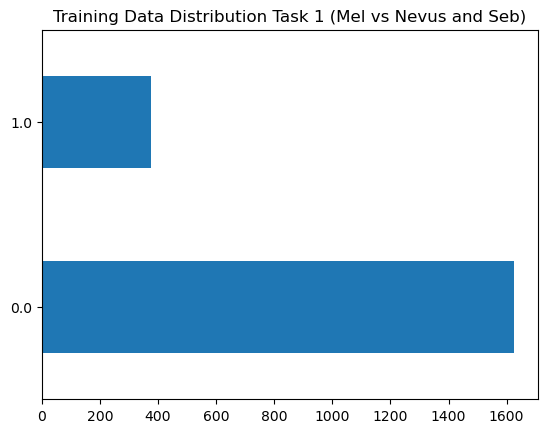

In [63]:
#plot for train data distribution task 1 (Mel vs Nevus_Seborrehic_Keratosis)
df_train["melanoma"].value_counts().plot(kind="barh", title="Training Data Distribution Task 1 (Mel vs Nevus and Seb)")

<AxesSubplot:title={'center':'Training Data Distribution Task 2 (Seb vs Nevus and Mel)'}>

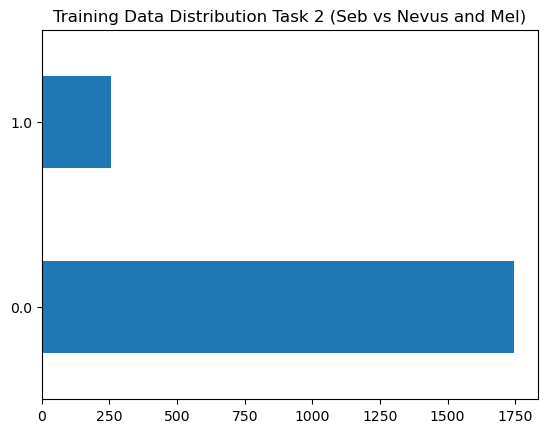

In [64]:
#plot for train data distribution task 1 (Seb vs Nevus and Mel)
df_train["seborrheic_keratosis"].value_counts().plot(kind="barh", title="Training Data Distribution Task 2 (Seb vs Nevus and Mel)")

In [65]:
#plot for test data distribution task 1 (Mel vs Nevus_Seborrehic_Keratosis)
df_test["melanoma"].value_counts()

0.0    483
1.0    117
Name: melanoma, dtype: int64

In [66]:
#plot for test data distribution task 2 (Seb vs Nevus_Mel)
df_test["seborrheic_keratosis"].value_counts()

0.0    510
1.0     90
Name: seborrheic_keratosis, dtype: int64

In [67]:
#plot for test data distribution task 1 (Mel vs Nevus_Seborrehic_Keratosis)
df_val["melanoma"].value_counts()

0.0    120
1.0     30
Name: melanoma, dtype: int64

In [69]:
#plot for test data distribution task 2 (Seb vs Nevus_Mel)
df_val["seborrheic_keratosis"].value_counts()

0.0    108
1.0     42
Name: seborrheic_keratosis, dtype: int64

In [70]:
#resizing images
def resize_images_in_folder(input_folder, output_folder, new_size = (224, 224)):    
    """
    Resize images in the input folder and save them in the output folder.

    Parameters:
    input_folder (str): Path to the folder containing the input images.
    output_folder (str): Path to the folder where resized images will be saved.
    new_size (tuple): Tuple representing the new size in the format (width, height).
    """
    
    print(f"Resizing images in {input_folder} and saving it to {output_folder}")
    
    os.makedirs(output_folder, exist_ok=True)

    # Get a list of all files in the input folder
    files = os.listdir(input_folder)

    for file in files:
        # Check if the file is an image (ends with .jpg or .jpeg)
        if file.lower().endswith(('.jpg', '.jpeg')):
            input_path = os.path.join(input_folder, file)
            output_path = os.path.join(output_folder, file)

            # Open the image using PIL
            image = Image.open(input_path)

            # Resize the image
            """
            Using Resampling.LANCZOS
            Calculate the output pixel value using a high-quality Lanczos filter
            (a truncated sinc) on all pixels that may contribute to the output value.
            """
            resized_image = image.resize(new_size, Image.Resampling.LANCZOS)#

            # Save the resized image to the output folder
            resized_image.save(output_path)
            
    print("Resizing Done!")

In [71]:
#Resizing images and replacing them to the same directory
resize_images_in_folder(train_dir, train_dir)
resize_images_in_folder(test_dir, test_dir)
resize_images_in_folder(val_dir, val_dir)

Resizing images in D:/msc/data/ISIC-2017_Training_Data and saving it to D:/msc/data/ISIC-2017_Training_Data
Resizing Done!
Resizing images in D:/msc/data/ISIC-2017_Test_v2_Data and saving it to D:/msc/data/ISIC-2017_Test_v2_Data
Resizing Done!
Resizing images in D:/msc/data/ISIC-2017_Validation_Data and saving it to D:/msc/data/ISIC-2017_Validation_Data
Resizing Done!


In [72]:
# Create new directories to store the data for each task type
train_task1_dir = os.path.join(train_dir, "D:/msc/data/train/task1")
train_task2_dir = os.path.join(train_dir, "D:/msc/data/train/task2")

test_task1_dir = os.path.join(test_dir, "D:/msc/data/test/task1")
test_task2_dir = os.path.join(test_dir, "D:/msc/data/test/task2")

val_task1_dir = os.path.join(val_dir, "D:/msc/data/val/task1")
val_task2_dir = os.path.join(val_dir, "D:/msc/data/val/task2")

os.makedirs(train_task1_dir, exist_ok=True)
os.makedirs(train_task2_dir, exist_ok=True)

os.makedirs(test_task1_dir, exist_ok=True)
os.makedirs(test_task2_dir, exist_ok=True)

os.makedirs(val_task1_dir, exist_ok=True)
os.makedirs(val_task2_dir, exist_ok=True)

In [73]:
#task 1
def task1_spliter(df, data_dir, final_dir):
    
    """
    function to split data (train, test, validation, etc.),
    for task1 Mel vs Nevu and Seb into seperate folders.
    """
    #initalizing a counter
    count1 = 0
    count2 = 0
    for index, row in df.iterrows():
        image_id = row["image_id"]
        task1_label = row["melanoma"]

        src_path = os.path.join(data_dir, image_id + ".jpg")

        if task1_label == 1.0:       
            dst_dir = os.path.join(final_dir, "mel")
            count1 += 1
        else:
            dst_dir = os.path.join(final_dir, "combined")
            count2 += 1

        dst_path = os.path.join(dst_dir, image_id + ".jpg")
        os.makedirs(dst_dir, exist_ok=True)
        shutil.copy(src_path, dst_path)
        
    print(f"Mel: {count1}, Nevus and Seb: {count2}, Total: {count1 + count2}")

In [74]:
task1_spliter(df_train, train_dir, train_task1_dir)#training
task1_spliter(df_test, test_dir, test_task1_dir)#test
task1_spliter(df_val, val_dir, val_task1_dir)#validation

Mel: 374, Nevus and Seb: 1626, Total: 2000
Mel: 117, Nevus and Seb: 483, Total: 600
Mel: 30, Nevus and Seb: 120, Total: 150


In [75]:
#task 2
def task2_spliter(df, data_dir, final_dir):
    
    """
    function to split data (train, test, validation, etc.),
    for task2 Seb vs Nevu and Mel into seperate folders.
    """
    #initalizing a counter
    count1 = 0
    count2 = 0
    for index, row in df.iterrows():
        image_id = row["image_id"]
        task1_label = row["seborrheic_keratosis"]

        src_path = os.path.join(data_dir, image_id + ".jpg")

        if task1_label == 1.0:       
            dst_dir = os.path.join(final_dir, "Seb")
            count1 += 1
        else:
            dst_dir = os.path.join(final_dir, "combined")
            count2 += 1

        dst_path = os.path.join(dst_dir, image_id + ".jpg")
        os.makedirs(dst_dir, exist_ok=True)
        shutil.copy(src_path, dst_path)

        
    print(f"Seb: {count1}, Nevu and Mel: {count2}, Total: {count1 + count2}")

In [76]:
task2_spliter(df_train, train_dir, train_task2_dir)#training
task2_spliter(df_test, test_dir, test_task2_dir)#test
task2_spliter(df_val, val_dir, val_task2_dir)#validation

Seb: 254, Nevu and Mel: 1746, Total: 2000
Seb: 90, Nevu and Mel: 510, Total: 600
Seb: 42, Nevu and Mel: 108, Total: 150


In [77]:
#Merging training and validation data for cross validation purpose
# Define source and destination directories
src_dirs = ["D:/msc/data/train", "D:/msc/data/val"]
dst_dir = "D:/msc/data/train_merged"

# Create destination directory
os.makedirs(dst_dir)

# Iterate over source directories
for src_dir in src_dirs:
    # Iterate over tasks
    for task in ["task1", "task2"]:
        # Define subdirectories
        subdirs = ["combined"]
        if task == "task1":
            subdirs.append("mel")
        elif task == "task2":
            subdirs.append("seb")
        
        # Iterate over subdirectories
        for subdir in subdirs:
            # Define source and destination subdirectories
            src_subdir = os.path.join(src_dir, task, subdir)
            dst_subdir = os.path.join(dst_dir, task, subdir)
            print(f"Coping contents of {src_subdir} into {dst_subdir}")
            
            # Create destination subdirectory
            os.makedirs(dst_subdir, exist_ok=True)
            
            # Copy files from source to destination
            for file_name in os.listdir(src_subdir):
                src_file = os.path.join(src_subdir, file_name)
                dst_file = os.path.join(dst_subdir, file_name)
                shutil.copy2(src_file, dst_file)

print("Merging Done!")

Coping contents of D:/msc/data/train\task1\combined into D:/msc/data/train_merged\task1\combined
Coping contents of D:/msc/data/train\task1\mel into D:/msc/data/train_merged\task1\mel
Coping contents of D:/msc/data/train\task2\combined into D:/msc/data/train_merged\task2\combined
Coping contents of D:/msc/data/train\task2\seb into D:/msc/data/train_merged\task2\seb
Coping contents of D:/msc/data/val\task1\combined into D:/msc/data/train_merged\task1\combined
Coping contents of D:/msc/data/val\task1\mel into D:/msc/data/train_merged\task1\mel
Coping contents of D:/msc/data/val\task2\combined into D:/msc/data/train_merged\task2\combined
Coping contents of D:/msc/data/val\task2\seb into D:/msc/data/train_merged\task2\seb
Merging Done!
